In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.cross_validation import KFold


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


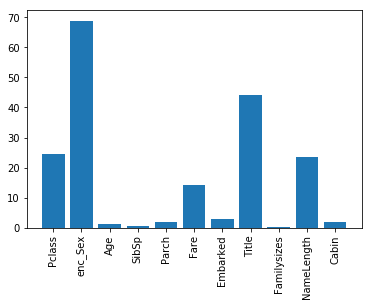

In [15]:
X=pd.read_csv('train.csv')
X2=pd.read_csv('train.csv')
test1 = pd.read_csv('test.csv')
y=X.pop("Survived")

X["Embarked"]=X["Embarked"].fillna("S")
X.loc[X["Embarked"]=="S","Embarked"]=0
X.loc[X["Embarked"]=="C","Embarked"]=1
X.loc[X["Embarked"]=="Q","Embarked"]=2


X1 = X.select_dtypes(include=[np.number])
X1["Age"]=X1["Age"].fillna(X1["Age"].median())
X1=X1.drop(['PassengerId'],axis=1)

categoricals = X.select_dtypes(exclude=[np.number])

# print(categoricals.describe())

# print (X.Embarked.value_counts(), "\n")
def encode1(x): return 1 if x == 'male' else 0
X1['enc_Sex'] = X.Sex.apply(encode1)
pd.set_option('display.max_rows', None)


X1["Familysizes"]=X["SibSp"]+X["Parch"]
X1["NameLength"]=X["Name"].apply(lambda x: len(x))


train_test_data = [X] # combining train and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)


X1["Title"]=X["Title"]


# print(X.Cabin.value_counts())
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]


cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)
X1["Cabin"]=X["Cabin"]
    
X1["Cabin"]=X1["Cabin"].fillna(X1["Cabin"].median())
# print(X1)


# print(X1.describe())



# print(type(titles))
# print(X1.head())
# print(X1)
# print(X1.describe())
# print(len(X1["Title"]))

predictors = ["Pclass" , "enc_Sex" , "Age" , "SibSp" ,"Parch" , "Fare" ,"Embarked","Title"
              ,"Familysizes","NameLength","Cabin"]
selector=SelectKBest(f_classif,k=5)
selector.fit(X1[predictors],y)
scores=-np.log10(selector.pvalues_)
plt.bar(range(len(predictors)),scores)
plt.xticks(range(len(predictors)),predictors,rotation="vertical")
plt.show()

X1=X1.drop(['Familysizes','SibSp','Parch','Age','Embarked','NameLength'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X1,y,random_state=42,test_size=0)



In [3]:
clf = XGBClassifier()
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
#      max_depth=200, random_state=0)
# clf = KNeighborsClassifier(n_neighbors = 13)
# clf = GaussianNB()
# clf = SVC()
# clf = DecisionTreeClassifier()
# clf = RandomForestClassifier(n_estimators=1000,  max_depth=1000,  
# min_samples_split=4, min_samples_leaf=2)
clf.fit(X_train, y_train)

k_fold =KFold(X1.shape[0], n_folds=3, random_state=1)
scoring = 'accuracy'
score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print (score.mean())





[ 0.79461279  0.83164983  0.82828283]
0.818181818182


In [17]:
algorithms=[[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3),\
            ["Pclass" , "enc_Sex" , "Fare" ,"Title"]],[DecisionTreeClassifier(random_state=1),\
            ["Pclass" , "enc_Sex"   ,  "Title"]]]
kf=KFold(X1.shape[0], n_folds=3, random_state=1)
predictions=[]
for train,test in kf:
    train_target=X2["Survived"].iloc[train]
    full_test_predictions=[]
    for alg, predictors in algorithms:
        alg.fit(X1[predictors].iloc[train,:],train_target)
        test_predictions=alg.predict_proba(X1[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    test_predictions=(full_test_predictions[0]+full_test_predictions[1])/2
    test_predictions[test_predictions<=0.5]=0
    test_predictions[test_predictions>0.5]=1
    predictions.append(test_predictions)
predictions=np.concatenate(predictions,axis=0)    
accuracy=sum(predictions[predictions==X2["Survived"]])/len(predictions)
print (accuracy)

KeyError: "['Parch' 'Familysizes' 'Age' 'Embarked'] not in index"

In [4]:
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
#      max_depth=200, random_state=0)
# clf.fit(X_train, y_train)
# k_fold = KFold(n_splits=3, shuffle=True, random_state=1)
# scoring = 'accuracy'
# score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
# print (score.mean())

In [5]:
# clf = KNeighborsClassifier(n_neighbors = 13)
# clf.fit(X_train, y_train)
# k_fold = KFold(n_splits=3, shuffle=True, random_state=1)
# scoring = 'accuracy'
# score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
# print (score.mean())

In [6]:
# clf = GaussianNB()
# clf.fit(X_train, y_train)
# k_fold = KFold(n_splits=3, shuffle=True, random_state=1)
# scoring = 'accuracy'
# score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
# print (score.mean())

In [7]:
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# k_fold = KFold(n_splits=3, shuffle=True, random_state=1)
# scoring = 'accuracy'
# score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
# print (score.mean())

In [8]:
# clf = RandomForestClassifier(n_estimators=1000,  max_depth=1000,  
#     min_samples_split=4, min_samples_leaf=2)
# clf.fit(X_train, y_train)
# k_fold = KFold(n_splits=3, shuffle=True, random_state=1)
# scoring = 'accuracy'
# score = cross_val_score(clf, X1, y, cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
# print (score.mean())

In [9]:
test1["Embarked"]=test1["Embarked"].fillna("S")
test1.loc[test1["Embarked"]=="S","Embarked"]=0
test1.loc[test1["Embarked"]=="C","Embarked"]=1
test1.loc[test1["Embarked"]=="Q","Embarked"]=2

test = test1.select_dtypes(include=[np.number])
test["Age"]=test["Age"].fillna(test["Age"].median())
test["Fare"]=test["Fare"].fillna(test["Fare"].median())
test['enc_Sex'] = test1.Sex.apply(encode1)
test=test.drop(['PassengerId'],axis=1)

test["Familysizes"]=test1["SibSp"]+test1["Parch"]
test["NameLength"]=test1["Name"].apply(lambda x: len(x))



train_test_data1 = [test1] # combining train and test dataset

for dataset in train_test_data1:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data1:
    dataset['Title'] = dataset['Title'].map(title_mapping)


test["Title"]=test1["Title"]

for dataset in train_test_data1:
    dataset['Cabin'] = dataset['Cabin'].str[:1]


cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data1:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)
test["Cabin"]=test1["Cabin"]
    
test["Cabin"]=test["Cabin"].fillna(test["Cabin"].median())
# print(test)

# print(test.describe())



test=test.drop(['Familysizes','SibSp','Parch','Age','Embarked','NameLength'],axis=1)


# print(test)
# print(test.describe())
# print(test)

In [10]:
# clf = XGBClassifier()
# clf.fit(X_train, y_train)
prediction = clf.predict(test)


submission = pd.DataFrame({
        "PassengerId": test1["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission.csv', index=False)